(1268, 40)

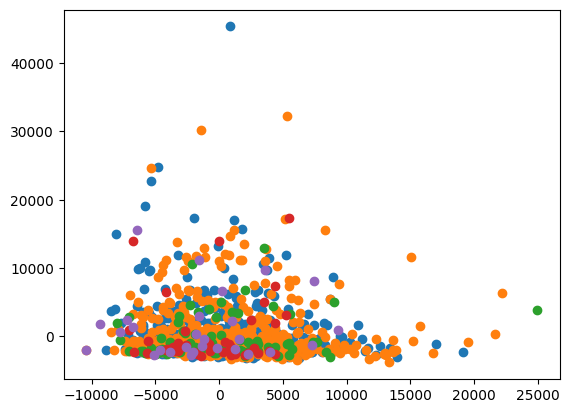

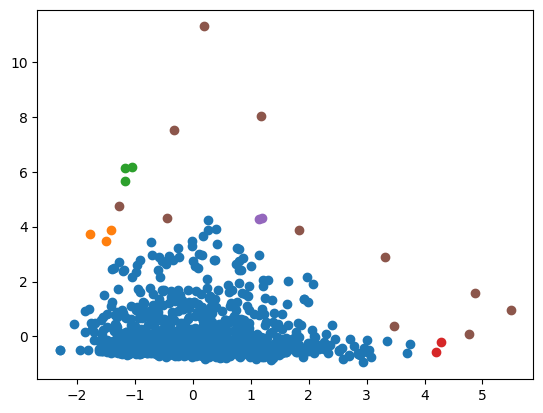

In [11]:
import pandas as pd
from matplotlib import pyplot as pl
import numpy as np
import csv
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from statistics import mode

#df = pd.read_csv('../HackathonMicrobiomeData/T2D/SpeciesT2D_train.csv')
#df = pd.read_csv('../src/unionMatrix.csv')
df = pd.read_csv('unionMatrix_Class.csv')


def createMetricsMatrix(df):
    metrics = []
    header = df.columns.values[1:]
    metrics.append(header)
    #meanMatrix = np.zeros((len(header)+1, len(header)))
    # header dataframes.columns.values[1:]
    metrics.append([])
    metrics.append([])
    #metrics.append([])
    for i in range(1, df.shape[1]-1):
        column = df.iloc[:,i].values
        metrics[1].append(np.mean(column))
        #meanMatrix[i-1,j-1] = np.mean(df.iloc[:,i].values)
        metrics[2].append(np.std(column))
        #metrics[3].append((metrics[2][i-1] / metrics[1][i-1])/len(column)**0.5)

    return metrics

def getIndicesWithLowByMeanThreshhold(df, threshhold):
    header = df.columns.values[1:-1]
    df_new = df
    for i in range(1, df.shape[1]-1):
        column = df.iloc[:,i].values
        if np.mean(column) < threshhold:
            df_new = df_new.drop(columns=header[i-1])
    return df_new

def boxplotHealthyAndSick(df):
    df_healthy = df[(df.label == 0)]
    df_sick = df[(df.label == 1)]

    plt.figure(1)
    df_healthy.boxplot()
    plt.figure(2)
    df_sick.boxplot()

def pca(df):
    df_tmp = df.copy()
    pca = PCA(n_components=2)
    header = df_tmp.columns.values[1:]
    df_withoutLabels = df_tmp.drop(columns=header[-1])
    principalComponents = pca.fit_transform(df_withoutLabels.values)
    df_principal_components = pd.DataFrame(principalComponents)
    df_principal_components['label'] = df.iloc[:,-1].values
    df_pc_healthy = df_principal_components[(df_principal_components.label == 0)]
    df_pc_T2D = df_principal_components[(df_principal_components.label == 1)]
    df_pc_IBD = df_principal_components[(df_principal_components.label == 2)]
    df_pc_CAD = df_principal_components[(df_principal_components.label == 3)]
    df_pc_CKD = df_principal_components[(df_principal_components.label == 4)]
    df_pc_healthy = df_pc_healthy.drop(columns=header[-1])
    df_pc_T2D = df_pc_T2D.drop(columns=header[-1])
    df_pc_IBD = df_pc_IBD.drop(columns=header[-1])
    df_pc_CAD = df_pc_CAD.drop(columns=header[-1])
    df_pc_CKD = df_pc_CKD.drop(columns=header[-1])

    plt.figure(3)
    plt.scatter(np.array(df_pc_healthy.values[0:, 0]), np.array(df_pc_healthy.values[0:, 1]))
    plt.scatter(np.array(df_pc_T2D.values[0:, 0]), np.array(df_pc_T2D.values[0:, 1]))
    plt.scatter(np.array(df_pc_IBD.values[0:, 0]), np.array(df_pc_IBD.values[0:, 1]))
    plt.scatter(np.array(df_pc_CAD.values[0:, 0]), np.array(df_pc_CAD.values[0:, 1]))
    plt.scatter(np.array(df_pc_CKD.values[0:, 0]), np.array(df_pc_CKD.values[0:, 1]))

    return df_principal_components

def clustering(df):
    df_tmp = df.copy()
    header = df_tmp.columns.values[1:]
    #print(df.drop(columns=header[-1]))
    df_n = StandardScaler().fit_transform(df_tmp.drop(columns=header[-1]).values)
    clustering = DBSCAN(eps=0.5, min_samples=2).fit(df_n)
    labels = df.iloc[:,-1].values

    df_tmp = pd.DataFrame(df_n)
    df_tmp['cluster'] = clustering.labels_
    clusterDf = []
    for i in set(clustering.labels_):
        clusterDf.append(df_tmp[(df_tmp.cluster == i)])

    plt.figure(4)
    header = df_tmp.columns.values[1:]
    for cDf in clusterDf:
        cDf_tmp = cDf.drop(columns=header[-1]).values
        plt.scatter(np.array(cDf_tmp[0:, 0]), np.array(cDf_tmp[0:, 1]))

    return clustering.labels_

def removeNoise(df, clusterLabels, keepMainCluster=True):
    df['cluster'] = clusterLabels
    if(keepMainCluster):
        df = df[(df.cluster != -1)]
    else:
        mainCluster = mode(clusterLabels)
        df = df[(df.cluster == mainCluster)]


    return df.drop(columns='cluster')

def reduceData(df):
    df_pca = pca(df.iloc[0:, 1:])
    clusterLabels = clustering(df_pca)
    df_reduced = removeNoise(df, clusterLabels, False)
    return df_reduced


# metrics = createMetricsMatrix(df)
#
# df_new = getIndicesWithLowByMeanThreshhold(df, 2)
#
# boxplotHealthyAndSick(df_new)
#
# plt.figure(3)
# df_pca = pca(df_new.iloc[0:, 1:])
#
# clusterLabels = clustering(df_pca)
#
# df_red = removeNoise(df_new, clusterLabels)
#
# print('Original shape', df.shape)
# # df new contains a cluster column, which is why it has a column more
# print('Original reduced bacterias', df_new.shape)
# print('Original reduced variables and patients', df_red.shape)

df = reduceData(df)

#df.shape
